# Federated Learning of Cohorts (FLoC) - Google's solution for interest based advertising in a world without third-party cookies

![cookies](food-photographer-jennifer-pallian-OfdDiqx8Cz8-unsplash.jpg)

Photo by <a href="https://unsplash.com/@foodess?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Food Photographer | Jennifer Pallian</a> on <a href="/s/photos/cookie?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

## The end of third-party cookies for advertisers

Third-party cookies have (since 1994) been a key enabler of the commercial Internet and **fine-grained digital ad targeting**

They have helped achieve **unprecedented audience segmentation and attribution** - helping to connect marketing tactics with results in ways that were virtually impossible in the most traditional forms of media.

To bring users more transparency and better consent management, most browsers are ending support for third-party cookies.

- [Firefox 79 clears redirect tracking cookies every 24 hours](https://venturebeat.com/2020/08/04/mozilla-firefox-79/)
- [Apple teases new tracking protections and an approximate location feature in iOS 14](https://www.theverge.com/2020/6/22/21299407/apple-ios-14-new-privacy-features-data-location-tracking-premissions-wwdc-2020)
- [Google has announced plans to stop supporting third-party cookies on its Chrome browser in 2021](https://blog.chromium.org/2020/01/building-more-private-web-path-towards.html)

Some alternatives are being proposed to replace the need for third-party cookies, ensuring users' privacy, but without loss of performance for advertisers.

In this post you will learn a little more about **Federated Learning of Cohorts (FLoC)**, an alternative proposed by Google, and we will navigate through a simplified demonstration of the algorithm using a public dataset.

# Federated Learning of Cohorts (FLoC)

## Goal
> **"Preserve interest based advertising, but in a privacy-preserving manner"**

### Overview
- Relies on a **cohort** assigning mechanism: a function that allocates a cohort id to a user based on their **browsing history**
- This cohort id **must be shared by at least k distinct users** for privacy

### Privacy x Utility
> "The more users share a cohort id, the **harder it is to derive individual** user's behavior from across the web. On the other hand, a large cohort is more likely to have a diverse set of users, thus making it harder to use this information for **fine-grained ads personalization** purposes."

**Ideal cohort assignment**: group together a large number of users interested in similar things

### Intersections with Data Science
- [Federated Learning](https://federated.withgoogle.com/): machine learning technique that trains an algorithm across multiple decentralized edge devices or servers holding local data samples, **without exchanging them**
- Cohort assignment algorithm should be **unsupervised**, since each provider has their own optimization function

## Evaluating Google's approach on a public dataset
- Let's evaluate [SimHash](https://static.googleusercontent.com/media/research.google.com/pt-BR//pubs/archive/33026.pdf) (originally developed to identify near duplicate documents quickly) proposed in the FLoC whitepaper as a cohort assignment mechanism using the dataset **MovieLens 25M**

> "MovieLens 25M movie ratings. Stable benchmark dataset. 25 million ratings and one million tag applications applied to 62,000 movies by 162,000 users."

## Installing the SimHash Python package

In [4]:
# !git clone https://github.com/scrapinghub/python-simhash
# !cd python-simhash && python setup.py install

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud
from simhash import weighted_fingerprint, fnvhash

## Downloading MovieLens 25m

In [2]:
# !wget https://files.grouplens.org/datasets/movielens/ml-25m.zip --no-check-certificate
# !unzip ml-25m.zip

In [3]:
movies = pd.read_csv("ml-25m/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv("ml-25m/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
# join movie genres with user ratings
df = ratings[["userId", "movieId", "rating"]].merge(movies[["movieId", "genres"]], on="movieId")
df["genres"] = df["genres"].apply(lambda x: x.split("|"))

# create a genre per column dataset
mlb = MultiLabelBinarizer(sparse_output=True)
transformed_df = df.join(
    pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df.pop("genres")),
        index=df.index,
        columns=mlb.classes_,
    )
)

# multiply user rating to each genre to give us an idea of a weighted genre vector for each user
my_genres = [col for col in transformed_df.columns if col not in ["userId", "movieId", "rating"]]
for genre in my_genres:
    transformed_df[genre] = transformed_df["rating"] * transformed_df[genre]
    transformed_df[genre] = np.asarray(transformed_df[genre]).astype("int8")

# compute each users' mean genre vector
transformed_df = transformed_df.drop(columns=["rating", "movieId"])
transformed_df = transformed_df.groupby(by="userId").mean()
transformed_df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.228571,0.557143,0.114286,0.157143,1.200000,0.442857,0.028571,2.785714,0.228571,0.042857,0.042857,0.000000,0.257143,0.185714,1.014286,0.242857,0.300000,0.271429,0.028571
2,0.000000,1.266304,1.521739,0.304348,0.456522,1.065217,0.282609,0.000000,1.679348,0.597826,0.000000,0.065217,0.152174,0.184783,0.152174,0.548913,0.581522,0.597826,0.266304,0.065217
3,0.004573,1.768293,1.060976,0.294207,0.260671,0.888720,0.756098,0.013720,1.335366,0.420732,0.032012,0.231707,0.442073,0.032012,0.341463,0.310976,1.198171,1.278963,0.141768,0.042683
4,0.000000,1.735537,1.330579,0.413223,0.338843,1.119835,0.561983,0.082645,0.719008,0.417355,0.000000,0.119835,0.363636,0.099174,0.264463,0.132231,1.024793,0.752066,0.115702,0.095041
5,0.000000,0.663366,0.801980,0.148515,0.297030,1.732673,0.574257,0.000000,1.702970,0.277228,0.000000,0.138614,0.118812,0.257426,0.326733,0.702970,0.445545,0.950495,0.089109,0.148515


## SimHash

Having computed each users' mean genre vector preferences, we can compute the SimHash on this vector, so each user interest will be represented by some hash of all of his preferences combined (with collisions)

In [6]:
def simhash(v):
    v = dict(v)
    return weighted_fingerprint([(fnvhash(k), w) for k, w in v.items()])

transformed_df['hash'] = transformed_df.apply(simhash, axis=1)
transformed_df['hash'].head()

userId
1   -4168514613323985072
2   -6481117420048840365
3   -6482326882838345121
4   -6482362067211401089
5   -5895715439450485934
Name: hash, dtype: int64

- We can see that we have a lot of collisions using SimHash, but this is expected, since many users share similar preferences and our choice of hashing algorithm is intentional
- SimHash is computationally inexpensive by design, not caring too much about hash collisions

In [7]:
pd.DataFrame(
    transformed_df["hash"]
    .value_counts()
).reset_index().rename(
    columns={
        "hash": "user_count",
        "index": "hash",
}).head(10)

,hash,user_count
0,-1862671604127069358,928
1,-1286210852092081326,654
2,-1862671604127069360,646
3,-1295288420091524270,595
4,-1283959052311950510,577
5,-3015592954098315456,527
6,-1295288419823088814,523
7,-1283959052316144782,489
8,-1871749172126512302,474
9,-3589802028227063950,466


## Defining a limited number of cohorts for demonstration purposes

Ideally, a cohort groups together a large number of users interested in similar things so that we can correctly target advertising that interests that group of people.

Next, we will limit the number of cohorts arbitrarily to five so that we can visually identify common preferences. In a real scenario, we would have another type of "hash grouping" to meet privacy and performance requirements.

In [8]:
transformed_df["cluster"] = pd.cut(transformed_df["hash"], bins=5, labels=["1", "2", "3", "4", "5"])
results = transformed_df.drop(columns='hash').groupby('cluster').mean()
weighted_results = results / results.mean()

## Visualizing the cohorts

In [15]:
def plot_cluster_wordcloud(cluster_name):
    cluster_text = weighted_results.loc[weighted_results.index == str(cluster_name)].to_dict(orient='records')[0]
    wordcloud = WordCloud(width=800, height=450, background_color="white").generate_from_frequencies(cluster_text)
    plt.figure(figsize=(16,9))
    plt.imshow(wordcloud)
    plt.axis("off");

## Cohort 1
> Action, Adventure, Western, IMAX

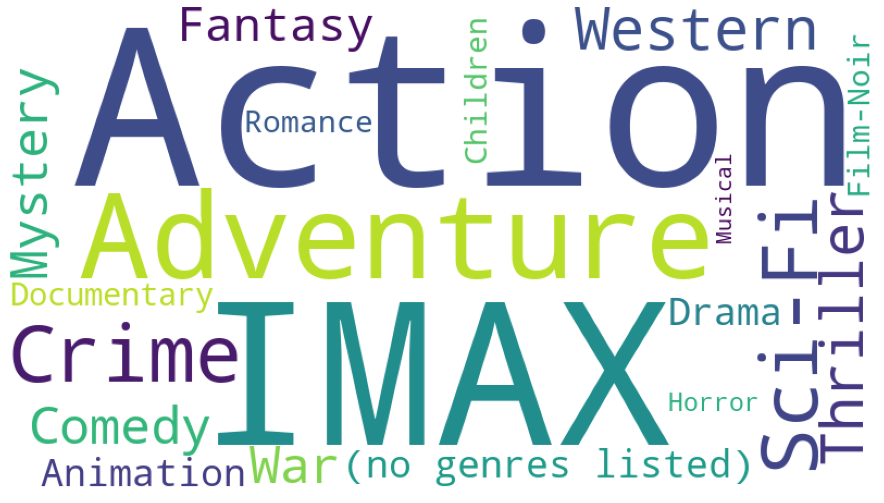

In [16]:
plot_cluster_wordcloud(1)

## Cohort 2
> Drama, Romance

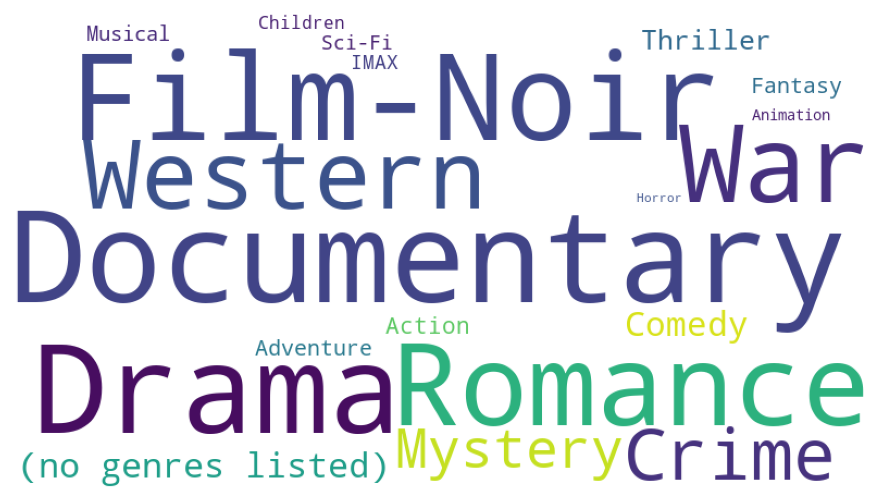

In [17]:
plot_cluster_wordcloud(2)

## Cohort 3
> Crime, Documentary, Mistery, Film-Noir

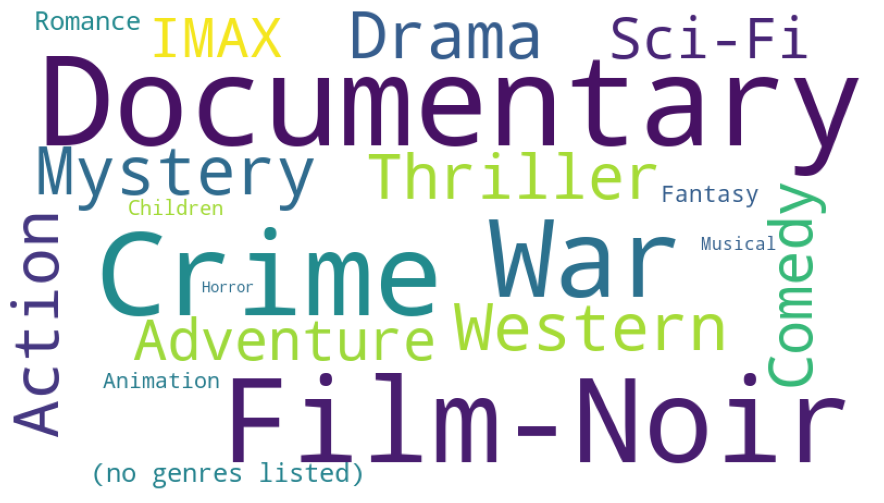

In [18]:
plot_cluster_wordcloud(3)

## Cohort 4
> Horror, Sci-Fi, Thriller

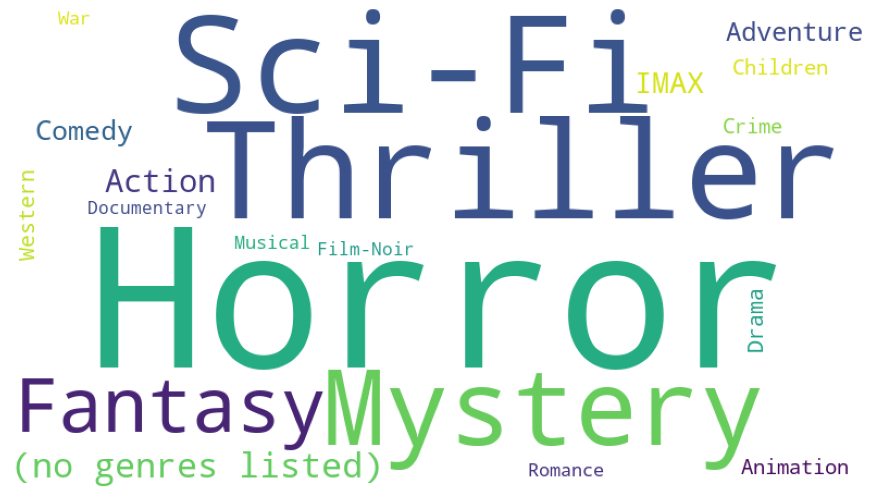

In [19]:
plot_cluster_wordcloud(4)

## Cohort 5
> Animation, Children, Comedy, Fantasy, Musical

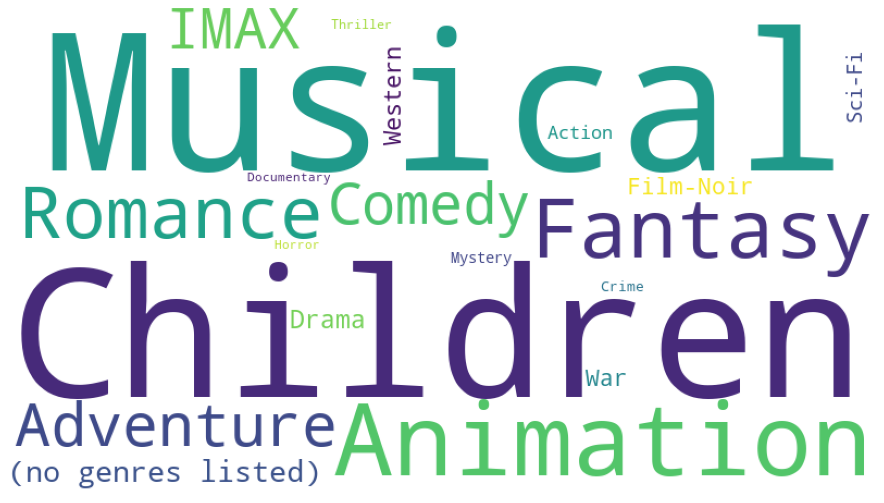

In [20]:
plot_cluster_wordcloud(5)

In [21]:
results_list = []
for i in range(1, 6):
    results_list.extend([results.loc[results.index == f"{i}"]])
    
results_df = pd.concat(results_list)
results_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
cluster,,,,,,,,,,,,,,,,,,,,
1,0.001502,1.439923,1.148764,0.286953,0.340513,1.213294,0.643127,0.015690,1.261012,0.451704,0.017685,0.250229,0.232444,0.123325,0.259208,0.522361,0.793502,1.136992,0.178779,0.075145
2,0.001924,0.297020,0.288078,0.072462,0.141363,1.218736,0.456177,0.041448,2.695759,0.201753,0.046458,0.083463,0.044277,0.151142,0.264121,1.394716,0.163069,0.511761,0.251440,0.059740
3,0.001667,0.804496,0.689763,0.215736,0.283569,1.173968,0.709943,0.045430,1.949370,0.367209,0.048596,0.171518,0.126948,0.149494,0.325944,0.771251,0.488943,0.891971,0.250467,0.066039
4,0.001796,0.564882,0.393516,0.111516,0.175711,0.716602,0.134440,0.004454,0.567647,0.544825,0.005383,2.555132,0.099205,0.113707,0.300746,0.208240,0.801416,1.209395,0.040161,0.019431
5,0.002033,0.304332,1.029229,1.065723,1.723622,1.515453,0.106870,0.004362,1.235150,1.012933,0.018621,0.128103,0.174525,1.611356,0.073465,1.250405,0.296731,0.173155,0.114797,0.038147


In [22]:
def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else: 
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

results_df.style.apply(highlight_max)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
cluster,,,,,,,,,,,,,,,,,,,,
1,0.001502,1.439923,1.148764,0.286953,0.340513,1.213294,0.643127,0.015690,1.261012,0.451704,0.017685,0.250229,0.232444,0.123325,0.259208,0.522361,0.793502,1.136992,0.178779,0.075145
2,0.001924,0.297020,0.288078,0.072462,0.141363,1.218736,0.456177,0.041448,2.695759,0.201753,0.046458,0.083463,0.044277,0.151142,0.264121,1.394716,0.163069,0.511761,0.251440,0.059740
3,0.001667,0.804496,0.689763,0.215736,0.283569,1.173968,0.709943,0.045430,1.949370,0.367209,0.048596,0.171518,0.126948,0.149494,0.325944,0.771251,0.488943,0.891971,0.250467,0.066039
4,0.001796,0.564882,0.393516,0.111516,0.175711,0.716602,0.134440,0.004454,0.567647,0.544825,0.005383,2.555132,0.099205,0.113707,0.300746,0.208240,0.801416,1.209395,0.040161,0.019431
5,0.002033,0.304332,1.029229,1.065723,1.723622,1.515453,0.106870,0.004362,1.235150,1.012933,0.018621,0.128103,0.174525,1.611356,0.073465,1.250405,0.296731,0.173155,0.114797,0.038147


# Conclusion

With the growing concern for users' privacy, some machine learning techniques have shown promise. **Federated learning** seems to be an interesting alternative for this type of application and it is worth studying it further.

I recommend that you read more about [Privacy Sandbox](https://blog.google/products/ads-commerce/2021-01-privacy-sandbox), Chrome's initiative to, according to Google, "help publishers and advertisers succeed, while protecting people's privacy."

# References
- [https://www.deloittedigital.com/us/en/blog-list/2020/what-the-end-of-third-party-cookies-means-for-advertisers.html](https://www.deloittedigital.com/us/en/blog-list/2020/what-the-end-of-third-party-cookies-means-for-advertisers.html)
- [https://venturebeat.com/2020/08/04/mozilla-firefox-79/](https://venturebeat.com/2020/08/04/mozilla-firefox-79/)
- [https://www.theverge.com/2020/6/22/21299407/apple-ios-14-new-privacy-features-data-location-tracking-premissions-wwdc-2020](https://www.theverge.com/2020/6/22/21299407/apple-ios-14-new-privacy-features-data-location-tracking-premissions-wwdc-2020)
- [https://blog.chromium.org/2020/01/building-more-private-web-path-towards.html](https://blog.chromium.org/2020/01/building-more-private-web-path-towards.html)
- [https://github.com/google/ads-privacy/blob/master/proposals/FLoC/FLOC-Whitepaper-Google.pdf](https://github.com/google/ads-privacy/blob/master/proposals/FLoC/FLOC-Whitepaper-Google.pdf)
- [https://blog.google/products/ads-commerce/2021-01-privacy-sandbox](https://blog.google/products/ads-commerce/2021-01-privacy-sandbox)
- [https://github.com/scrapinghub/python-simhash](https://github.com/scrapinghub/python-simhash)
- [https://towardsdatascience.com/federated-learning-of-cohorts-googles-cookie-killer-7f63b2395173](https://towardsdatascience.com/federated-learning-of-cohorts-googles-cookie-killer-7f63b2395173)